## Load and Visualize the Dataset

Dataset Link: [Kaggle-Butterfly Image Classification dataset](https://www.kaggle.com/datasets/phucthaiv02/butterfly-image-classification)

### Load Images

In [1]:
IMG_SIZE = (227, 227)

In [2]:
import pandas as pd
import tensorflow as tf
from PIL import Image
import numpy as np

pd.options.mode.chained_assignment = None

def load_img(img_path):
    img = Image.open(img_path)
    img = img.resize(IMG_SIZE)
    img_arr = np.array(img)
    return img_arr

ind_to_label = list()
label_to_ind = dict()

def load_ds(path, random_state=42):
    df = pd.read_csv(path + 'Training_set.csv')
    df = df.sample(frac=1, random_state=random_state)
    val_df = df[6000:]
    train_df = df[:6000]
    
    img_dir = path + 'train/'
    train_df['filepath'] = train_df['filename'].map(lambda x: img_dir + x)
    val_df['filepath'] = val_df['filename'].map(lambda x: img_dir + x)

    train_df['img'] = train_df['filepath'].map(load_img) / 255.
    val_df['img'] = val_df['filepath'].map(load_img) / 255.

    labels = set(train_df['label'])

    ind_to_label = list(labels)
    
    for i in range(0, len(ind_to_label)):
        label_to_ind[ind_to_label[i]] = i
    
    train_df['y'] = train_df['label'].map(lambda x: label_to_ind[x])
    val_df['y'] = val_df['label'].map(lambda x:label_to_ind[x])
    
    return train_df, val_df, labels

2025-04-11 19:07:55.155165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744398475.352921      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744398475.412531      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
train_df, val_df, labels = load_ds('/kaggle/input/butterfly-image-classification/')

In [4]:
train_df.head(2)

,filename,label,filepath,img,y
5572,Image_5573.jpg,GREEN CELLED CATTLEHEART,/kaggle/input/butterfly-image-classification/t...,"[[[0.9333333333333333, 0.9333333333333333, 0.9...",0
1703,Image_1704.jpg,MONARCH,/kaggle/input/butterfly-image-classification/t...,"[[[0.45098039215686275, 0.5294117647058824, 0....",49


### Visualize images

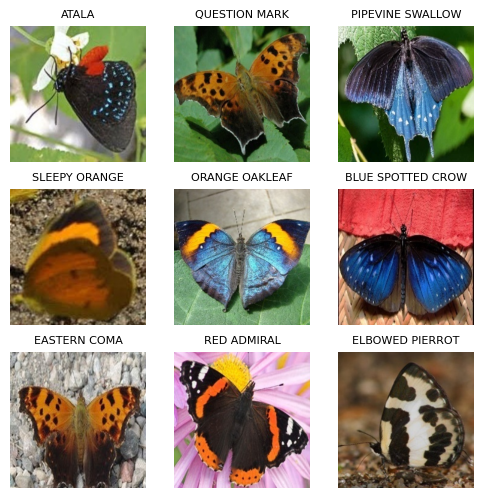

In [5]:
import matplotlib.pyplot as plt
import random

f, ax = plt.subplots(3, 3, figsize=(6, 6))

for i in range(0, 9):
    img_ind = random.randint(0, len(train_df))
    data_pt = train_df.iloc[img_ind]
    ax[i//3][i%3].imshow(data_pt['img'])
    ax[i//3][i%3].set_title(data_pt['label'], fontsize=8)
    ax[i//3][i%3].axis('off')

## Model architecture

In [6]:
INPUT_SHAPE = IMG_SIZE + (3,)
INPUT_SHAPE

(227, 227, 3)

### Naive model

In [ ]:
from functools import partial

def make_naive_model():
    DefaultConv2D = partial(
        tf.keras.layers.Conv2D,
        activation='tanh',
        kernel_size=3,
        padding='same',
        kernel_initializer='he_normal',
    )
    
    input = tf.keras.layers.Input(shape=INPUT_SHAPE)
    x = tf.keras.layers.Normalization()(input)
    x = DefaultConv2D(filters=64)(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = DefaultConv2D(filters=128)(x)
    x = DefaultConv2D(filters=128)(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = DefaultConv2D(filters=256)(x)
    x = DefaultConv2D(filters=256)(x)
    x = tf.keras.layers.MaxPool2D()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(units=200)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units=100)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units=100)(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Dense(units=100)(x)
    x = tf.keras.layers.Dense(units=len(labels))(x)
    
    return tf.keras.Model(inputs=input, outputs=x)

model = make_naive_model()
model.summary()

### AlexNet

In [7]:
from functools import partial

DefaultConv2D = partial(
    tf.keras.layers.Conv2D,
    activation='relu',
    kernel_size=3,
    padding='valid',
    kernel_initializer='he_normal',
)

model = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=INPUT_SHAPE, name='input'),
    DefaultConv2D(kernel_size=11, filters=96, strides=(4, 4), name='C1'),
    tf.keras.layers.MaxPool2D(name='S2'),
    DefaultConv2D(kernel_size=5, filters= 256, padding='same', name='C3'),
    tf.keras.layers.MaxPool2D(name='S4'),
    DefaultConv2D(filters=384, padding='same', name='C5'),
    DefaultConv2D(filters=384, padding='same', name='C6'),
    DefaultConv2D(filters=256, padding='same', name='C7'),
    tf.keras.layers.MaxPool2D(name='S8'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=4096, activation='relu', name='F9'),
    tf.keras.layers.Dense(units=4096, activation='relu', name='F10'),
    tf.keras.layers.Dense(units=len(labels), activation='softmax', name='output'),
])

model.summary()

I0000 00:00:1744398535.881129      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ C1 (Conv2D)                          │ (None, 55, 55, 96)          │          34,944 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S2 (MaxPooling2D)                    │ (None, 27, 27, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C3 (Conv2D)                          │ (None, 27, 27, 256)         │         614,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S4 (MaxPooling2D)                    │ (None, 13, 13, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C5 (Conv2D)                          │ (None, 13, 13, 384)         │         885,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C6 (Conv2D)                          │ (None, 13, 13, 384)         │       1,327,488 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ C7 (Conv2D)                          │ (None, 13, 13, 256)         │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ S8 (MaxPooling2D)                    │ (None, 6, 6, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 9216)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ F9 (Dense)                           │ (None, 4096)                │      37,752,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ F10 (Dense)                          │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ output (Dense)                       │ (None, 75)                  │         307,275 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 58,588,619 (223.50 MB)

 Trainable params: 58,588,619 (223.50 MB)

 Non-trainable params: 0 (0.00 B)

In [8]:
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
    optimizer='adam'
)

## Training model

In [9]:
train_X = np.stack(train_df['img'].values)
train_Y = train_df['y'].values

val_X = np.stack(val_df['img'].values)
val_Y = val_df['y'].values

print(train_X.shape, train_Y.shape)
print(val_X.shape, val_Y.shape)

(6000, 227, 227, 3) (6000,)
(499, 227, 227, 3) (499,)


In [ ]:
model.fit(
    x=train_X,
    y=train_Y,
    validation_data=(val_X, val_Y),
    epochs=500,
    batch_size=32
)

Epoch 1/500


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:635: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1744398553.522664     105 service.cc:148] XLA service 0x787cc40021c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1744398553.523885     105 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1744398553.920772     105 cuda_dnn.cc:529] Loaded cuDNN version 90300


  5/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0155 - loss: 18.7196

I0000 00:00:1744398558.878060     105 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


188/188 ━━━━━━━━━━━━━━━━━━━━ 21s 68ms/step - accuracy: 0.0130 - loss: 5.7581 - val_accuracy: 0.0120 - val_loss: 4.3224
Epoch 2/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0199 - loss: 4.3143 - val_accuracy: 0.0120 - val_loss: 4.3244
Epoch 3/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0203 - loss: 4.3143 - val_accuracy: 0.0120 - val_loss: 4.3306
Epoch 4/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0214 - loss: 4.3139 - val_accuracy: 0.0120 - val_loss: 4.3284
Epoch 5/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0226 - loss: 4.3111 - val_accuracy: 0.0120 - val_loss: 4.3267
Epoch 6/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0186 - loss: 4.3130 - val_accuracy: 0.0120 - val_loss: 4.3321
Epoch 7/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0224 - loss: 4.3099 - val_accuracy: 0.0120 - val_loss: 4.3276
Epoch 8/500
188/188 ━━━━━━━━━━━━━━━━━━━━ 6s 33ms/step - accuracy: 0.0191 - loss: 4.3116 - val_accurac